## Machine Learning Commute Model
### Created by Chris Brunet

In [1]:
import requests
import urllib3
import pandas as pd
import numpy as np
import pickle
import sklearn

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

import sys
print(sys.version)
print(sklearn.__version__)

3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]
1.3.2


### Step 1: Loading and Processing Strava Commute Data

In [2]:
def request_access_token(client_id, client_secret, refresh_token):
    """
    Post request to refresh and get new API access token

    Parameters:
        client_id: string
        client_secret: string
        refresh_token: string
    
    Returns:
        access_token: string
    """
    auth_url = "https://www.strava.com/oauth/token"
    payload = {
        'client_id': client_id,
        'client_secret': client_secret,
        'refresh_token': refresh_token,
        'grant_type': 'refresh_token',
        'f': 'json'
    }
    print("\nRequesting Access Token...")
    res = requests.post(auth_url, data=payload, verify=False)
    access_token = res.json()['access_token']
    print(f"\nAccess Token = {access_token}")
    return access_token

In [3]:
def get_activity_data(access_token):
    """
    Get request for Strava user activity data 

    Parameters:
        client_id: string
        client_secret: string
        refresh_token: string
    
    Returns:
        all_activities_df: DataFrame
        all_activities_list: list
    """
    print("\nGetting Activity Data...")
    activities_url = "https://www.strava.com/api/v3/athlete/activities"
    header = {'Authorization': 'Bearer ' + access_token}
    request_page_num = 1
    all_activities_list = []
    
    while True: # since max 200 activities can be accessed per request, while loop runs until all activities are loaded
        param = {'per_page': 200, 'page': request_page_num}
        get_activities = requests.get(activities_url, headers=header,params=param).json()
        if len(get_activities) == 0: # exit condition
            break
        all_activities_list.extend(get_activities)
        print(f'\t- Activities: {len(all_activities_list) - len(get_activities)} to {len(all_activities_list)}')
        request_page_num += 1
    
    all_activities_df = pd.DataFrame(all_activities_list)
    return all_activities_df

In [4]:
# Constant variables  
client_id = '111595'
client_secret = '8e8f246270159ece4b0eb3c75e494241bad86027'
refresh_token = '8285947a1614c22ebf0a7308cafb267ed4d9426f'

# API requests, getting and formatting Activity data and Segment data from Strava API
access_token = request_access_token(client_id, client_secret, refresh_token) # int
all_activities = get_activity_data(access_token) # DataFrame


Requesting Access Token...

Access Token = 9159d88ab3bde2e5fac3c0de398e3bdaa1fca35f

Getting Activity Data...
	- Activities: 0 to 200
	- Activities: 200 to 325


In [5]:
# creating commute dataframe to only include activities labeled as 'commute'
all_commutes = all_activities[all_activities['commute'] == True]
all_commutes

,resource_state,athlete,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,...,elev_low,upload_id,upload_id_str,external_id,from_accepted_tag,pr_count,total_photo_count,has_kudoed,workout_type,average_temp
1,2,"{'id': 54754532, 'resource_state': 1}",Afternoon Ride,6036.1,1016,1016,92.0,Ride,Ride,10196468104,...,1053.8,10920260140,10920260140,garmin_ping_304165618299,False,0,0,False,10.0,NaN
2,2,"{'id': 54754532, 'resource_state': 1}",Lunch Ride,6046.9,1074,1074,63.0,Ride,Ride,10195492833,...,1051.2,10919253970,10919253970,garmin_ping_304135706924,False,0,0,False,10.0,NaN
3,2,"{'id': 54754532, 'resource_state': 1}",Afternoon Ride,6096.4,1100,1502,77.0,Ride,Ride,10191591684,...,1053.6,10915199739,10915199739,garmin_ping_304008538649,False,0,0,False,10.0,NaN
4,2,"{'id': 54754532, 'resource_state': 1}",Morning Ride #commutemarker.com,6032.8,1053,1053,62.0,Ride,Ride,10189012200,...,1052.0,10912550727,10912550727,garmin_ping_303940892189,False,0,0,False,10.0,NaN
5,2,"{'id': 54754532, 'resource_state': 1}",Afternoon Ride #commutemarker.com,6079.7,1164,1302,79.0,Ride,Ride,10179536062,...,1053.6,10902744686,10902744686,garmin_ping_303660586498,False,0,0,False,10.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,2,"{'id': 54754532, 'resource_state': 1}",Afternoon Ride,6208.0,1135,1160,88.0,Ride,Ride,9011977219,...,1058.4,9668642605,9668642605,garmin_ping_272582649270,False,3,0,False,10.0,NaN
181,2,"{'id': 54754532, 'resource_state': 1}",Lunch Ride,6153.0,1050,1099,67.0,Ride,Ride,9010531477,...,1052.4,9667118367,9667118367,garmin_ping_272549041941,False,2,0,False,10.0,NaN
182,2,"{'id': 54754532, 'resource_state': 1}",Afternoon Ride,6251.7,1208,1291,88.0,Ride,Ride,9005702275,...,1057.0,9662020260,9662020260,garmin_ping_272414779651,False,1,0,False,10.0,NaN
183,2,"{'id': 54754532, 'resource_state': 1}",Morning Ride,6071.8,1152,1698,67.0,Ride,Ride,9003038263,...,1052.2,9659225433,9659225433,garmin_ping_272357926443,False,5,0,False,10.0,NaN


In [6]:
# checking for null values
all_commutes.isna().sum()

resource_state                     0
athlete                            0
name                               0
distance                           0
moving_time                        0
elapsed_time                       0
total_elevation_gain               0
type                               0
sport_type                         0
id                                 0
start_date                         0
start_date_local                   0
timezone                           0
utc_offset                         0
location_city                    121
location_state                   121
location_country                 121
achievement_count                  0
kudos_count                        0
comment_count                      0
athlete_count                      0
photo_count                        0
map                                0
trainer                            0
commute                            0
manual                             0
private                            0
v

In [7]:
# dropping unwanted columns
columns_to_keep = ['distance', 'moving_time', 'total_elevation_gain', 'start_date_local', 'start_latlng', 'end_latlng']
columns_to_drop = [col for col in all_commutes.columns if col not in columns_to_keep] 
all_commutes = all_commutes.drop(columns=columns_to_drop)

In [8]:
# establishing min and max distance to remove outliers from dataset
min_dist = 5000
max_dist = 7000
all_commutes = all_commutes[(all_commutes['distance'] > min_dist) & (all_commutes['distance'] < max_dist)]

In [9]:
# converting start_date_local to separate columns with date and time
all_commutes['start_datetime'] = pd.to_datetime(all_commutes['start_date_local'])
all_commutes['start_date'] = all_commutes['start_datetime'].dt.date
all_commutes['start_time'] = all_commutes['start_datetime'].dt.time
all_commutes = all_commutes.drop(columns=['start_datetime', 'start_date_local'])

In [10]:
# function to identify ride direction
def get_direction(row):
    if row['start_lat'] < row['end_lat']:
        return 'northbound'
    else:
        return 'southbound'

In [11]:
# applying get_direction function to latlng
all_commutes[['start_lat', 'start_lng']] = pd.DataFrame(all_commutes['start_latlng'].tolist(), index=all_commutes.index)
all_commutes[['end_lat', 'end_lng']] = pd.DataFrame(all_commutes['end_latlng'].tolist(), index=all_commutes.index)
all_commutes['direction'] = all_commutes.apply(get_direction, axis=1)
all_commutes = all_commutes.drop(columns=['start_latlng', 'end_latlng', 'start_lat', 'start_lng', 'end_lat', 'end_lng'])
all_commutes

,distance,moving_time,total_elevation_gain,start_date,start_time,direction
1,6036.1,1016,92.0,2023-11-10,17:00:41,southbound
2,6046.9,1074,63.0,2023-11-10,12:37:41,northbound
3,6096.4,1100,77.0,2023-11-09,17:19:17,southbound
4,6032.8,1053,62.0,2023-11-09,08:29:29,northbound
5,6079.7,1164,79.0,2023-11-07,15:34:23,southbound
...,...,...,...,...,...,...
178,6355.9,1289,66.0,2023-05-08,08:23:53,northbound
180,6208.0,1135,88.0,2023-05-04,14:17:18,southbound
181,6153.0,1050,67.0,2023-05-04,11:06:52,northbound
182,6251.7,1208,88.0,2023-05-03,15:26:02,southbound


### Step 2: Loading and Processing Calgary Weather Data

In [12]:
weather = pd.read_csv('en_climate_daily_AB_3031092_2023_P1D.csv')
weather

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,-114.01,51.12,CALGARY INTL A,3031092,2023-01-01,2023,1,1,NaN,2.4,...,0.0,NaN,0.0,NaN,3.0,NaN,NaN,M,NaN,M
1,-114.01,51.12,CALGARY INTL A,3031092,2023-01-02,2023,1,2,NaN,1.2,...,0.0,NaN,0.0,NaN,4.0,NaN,NaN,M,NaN,M
2,-114.01,51.12,CALGARY INTL A,3031092,2023-01-03,2023,1,3,NaN,1.1,...,0.0,NaN,0.0,NaN,5.0,NaN,NaN,M,NaN,M
3,-114.01,51.12,CALGARY INTL A,3031092,2023-01-04,2023,1,4,NaN,0.9,...,0.0,NaN,0.0,NaN,5.0,NaN,NaN,M,NaN,M
4,-114.01,51.12,CALGARY INTL A,3031092,2023-01-05,2023,1,5,NaN,-6.4,...,0.0,NaN,0.0,NaN,5.0,NaN,NaN,M,NaN,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,-114.01,51.12,CALGARY INTL A,3031092,2023-12-27,2023,12,27,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
361,-114.01,51.12,CALGARY INTL A,3031092,2023-12-28,2023,12,28,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362,-114.01,51.12,CALGARY INTL A,3031092,2023-12-29,2023,12,29,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
363,-114.01,51.12,CALGARY INTL A,3031092,2023-12-30,2023,12,30,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
weather.isna().sum()

Longitude (x)                  0
Latitude (y)                   0
Station Name                   0
Climate ID                     0
Date/Time                      0
Year                           0
Month                          0
Day                            0
Data Quality                 365
Max Temp (°C)                 52
Max Temp Flag                363
Min Temp (°C)                 52
Min Temp Flag                363
Mean Temp (°C)                52
Mean Temp Flag               363
Heat Deg Days (°C)            52
Heat Deg Days Flag           363
Cool Deg Days (°C)            52
Cool Deg Days Flag           363
Total Rain (mm)               50
Total Rain Flag              334
Total Snow (cm)               50
Total Snow Flag              344
Total Precip (mm)             50
Total Precip Flag            314
Snow on Grnd (cm)            251
Snow on Grnd Flag            345
Dir of Max Gust (10s deg)    115
Dir of Max Gust Flag         300
Spd of Max Gust (km/h)       115
Spd of Max

In [14]:
columns_to_keep = ['Date/Time', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)',
                  'Total Precip (mm)', 'Snow on Grnd (cm)', 'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)']
columns_to_drop = [col for col in weather.columns if col not in columns_to_keep] 
weather = weather.drop(columns=columns_to_drop)

In [15]:
weather['date_time'] = pd.to_datetime(weather['Date/Time']).dt.date
weather = weather.drop(columns='Date/Time')
weather

,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h),date_time
0,2.4,-8.2,-2.9,0.0,0.0,0.0,3.0,NaN,NaN,2023-01-01
1,1.2,-12.1,-5.5,0.0,0.0,0.0,4.0,NaN,NaN,2023-01-02
2,1.1,-13.0,-6.0,0.0,0.0,0.0,5.0,NaN,NaN,2023-01-03
3,0.9,-11.6,-5.4,0.0,0.0,0.0,5.0,NaN,NaN,2023-01-04
4,-6.4,-15.8,-11.1,0.0,0.0,0.0,5.0,NaN,NaN,2023-01-05
...,...,...,...,...,...,...,...,...,...,...
360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-12-27
361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-12-28
362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-12-29
363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-12-30


### Step 3: Joining and Processing Datasets

In [16]:
full_dataset = pd.merge(all_commutes, weather, left_on='start_date', right_on='date_time', how='left')
full_dataset

,distance,moving_time,total_elevation_gain,start_date,start_time,direction,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h),date_time
0,6036.1,1016,92.0,2023-11-10,17:00:41,southbound,8.6,-3.3,2.7,0.0,0.0,0.0,NaN,28.0,52.0,2023-11-10
1,6046.9,1074,63.0,2023-11-10,12:37:41,northbound,8.6,-3.3,2.7,0.0,0.0,0.0,NaN,28.0,52.0,2023-11-10
2,6096.4,1100,77.0,2023-11-09,17:19:17,southbound,7.0,-5.9,0.6,0.0,0.0,0.0,NaN,12.0,33.0,2023-11-09
3,6032.8,1053,62.0,2023-11-09,08:29:29,northbound,7.0,-5.9,0.6,0.0,0.0,0.0,NaN,12.0,33.0,2023-11-09
4,6079.7,1164,79.0,2023-11-07,15:34:23,southbound,9.4,-0.8,4.3,0.0,0.0,0.0,NaN,1.0,43.0,2023-11-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,6355.9,1289,66.0,2023-05-08,08:23:53,northbound,13.8,6.9,10.4,8.7,0.0,8.7,NaN,2.0,36.0,2023-05-08
113,6208.0,1135,88.0,2023-05-04,14:17:18,southbound,27.6,7.5,17.6,0.0,0.0,0.0,NaN,12.0,49.0,2023-05-04
114,6153.0,1050,67.0,2023-05-04,11:06:52,northbound,27.6,7.5,17.6,0.0,0.0,0.0,NaN,12.0,49.0,2023-05-04
115,6251.7,1208,88.0,2023-05-03,15:26:02,southbound,27.3,5.0,16.2,0.0,0.0,0.0,NaN,19.0,48.0,2023-05-03


In [17]:
full_dataset.isna().sum()

distance                       0
moving_time                    0
total_elevation_gain           0
start_date                     0
start_time                     0
direction                      0
Max Temp (°C)                  0
Min Temp (°C)                  0
Mean Temp (°C)                 0
Total Rain (mm)                0
Total Snow (cm)                0
Total Precip (mm)              0
Snow on Grnd (cm)            107
Dir of Max Gust (10s deg)     23
Spd of Max Gust (km/h)        23
date_time                      0
dtype: int64

In [18]:
full_dataset.columns

Index(['distance', 'moving_time', 'total_elevation_gain', 'start_date',
       'start_time', 'direction', 'Max Temp (°C)', 'Min Temp (°C)',
       'Mean Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)',
       'Total Precip (mm)', 'Snow on Grnd (cm)', 'Dir of Max Gust (10s deg)',
       'Spd of Max Gust (km/h)', 'date_time'],
      dtype='object')

In [19]:
full_dataset['Snow on Grnd (cm)'] = full_dataset['Snow on Grnd (cm)'].fillna(0)
full_dataset = full_dataset.dropna()
full_dataset = full_dataset.drop(columns=['date_time', 'start_date', 'start_time', 'distance', 'total_elevation_gain'])

In [20]:
full_dataset

,moving_time,direction,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
0,1016,southbound,8.6,-3.3,2.7,0.0,0.0,0.0,0.0,28.0,52.0
1,1074,northbound,8.6,-3.3,2.7,0.0,0.0,0.0,0.0,28.0,52.0
2,1100,southbound,7.0,-5.9,0.6,0.0,0.0,0.0,0.0,12.0,33.0
3,1053,northbound,7.0,-5.9,0.6,0.0,0.0,0.0,0.0,12.0,33.0
4,1164,southbound,9.4,-0.8,4.3,0.0,0.0,0.0,0.0,1.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...
112,1289,northbound,13.8,6.9,10.4,8.7,0.0,8.7,0.0,2.0,36.0
113,1135,southbound,27.6,7.5,17.6,0.0,0.0,0.0,0.0,12.0,49.0
114,1050,northbound,27.6,7.5,17.6,0.0,0.0,0.0,0.0,12.0,49.0
115,1208,southbound,27.3,5.0,16.2,0.0,0.0,0.0,0.0,19.0,48.0


### Step 4: Preprocessing and Model Selection

In [21]:
ct = ColumnTransformer(
    [("onehot", OneHotEncoder(sparse_output=False), ['direction']),
    ("scaler", StandardScaler(), ['Max Temp (°C)', 'Min Temp (°C)',
                                 'Mean Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
                                 'Snow on Grnd (cm)', 'Spd of Max Gust (km/h)'])],
    remainder='passthrough')

transformed_data = ct.fit_transform(full_dataset)

ct.get_feature_names_out()

array(['onehot__direction_northbound', 'onehot__direction_southbound',
       'scaler__Max Temp (°C)', 'scaler__Min Temp (°C)',
       'scaler__Mean Temp (°C)', 'scaler__Total Rain (mm)',
       'scaler__Total Snow (cm)', 'scaler__Total Precip (mm)',
       'scaler__Snow on Grnd (cm)', 'scaler__Spd of Max Gust (km/h)',
       'remainder__moving_time', 'remainder__Dir of Max Gust (10s deg)'],
      dtype=object)

In [22]:
X = full_dataset.drop('moving_time', axis=1)
y = full_dataset['moving_time']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

ct.fit(X_train)
X_train_trans = ct.transform(X_train)
print(X_train_trans.shape)

(70, 11)


In [23]:
rf = RandomForestRegressor()
lr = Lasso()

In [24]:
param_grid_rf = {
    'n_estimators': [1, 10, 100, 1000, 10000],
    'max_depth': [1, 10, 100, 1000, 10000]
}

param_grid_lr = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 1000, 10000, 100000]
}

In [25]:
grid_search_rf = GridSearchCV(rf, param_grid=param_grid_rf, scoring='neg_root_mean_squared_error', cv=5)
grid_search_lr = GridSearchCV(lr, param_grid=param_grid_lr, scoring='neg_root_mean_squared_error', cv=5)

In [26]:
grid_search_rf.fit(X_train_trans, y_train)
# grid_search_lr.fit(X_train_trans, y_train)

print("Random Forest Results:")
print("\n The best score across ALL searched params:\n",grid_search_rf.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_search_rf.best_params_)

# print("Lasso Regression Results:")
# print("\n The best score across ALL searched params:\n",grid_search_lr.best_score_)
# print("\n The best parameters across ALL searched params:\n",grid_search_lr.best_params_)

Random Forest Results:

 The best score across ALL searched params:
 -112.87587591015351

 The best parameters across ALL searched params:
 {'max_depth': 1000, 'n_estimators': 100}


In [27]:
pd.DataFrame(grid_search_rf.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001610,0.001303,0.000490,0.000232,1,1,"{'max_depth': 1, 'n_estimators': 1}",-199.618899,-190.143232,-77.078081,-156.143774,-78.421118,-140.281021,53.066204,22
1,0.003670,0.000168,0.000540,0.000021,1,10,"{'max_depth': 1, 'n_estimators': 10}",-148.592030,-201.001736,-65.256134,-80.887795,-88.065671,-116.760673,50.740075,10
2,0.032468,0.000594,0.002081,0.000059,1,100,"{'max_depth': 1, 'n_estimators': 100}",-139.838589,-201.050045,-69.347772,-95.853766,-88.203843,-118.858803,47.150508,15
3,0.288977,0.002578,0.015448,0.000043,1,1000,"{'max_depth': 1, 'n_estimators': 1000}",-144.422317,-203.093868,-68.910787,-89.121670,-83.116119,-117.732952,49.798278,13
4,2.900294,0.017441,0.164266,0.012105,1,10000,"{'max_depth': 1, 'n_estimators': 10000}",-141.712739,-202.594426,-68.295132,-92.036063,-84.696113,-117.866894,48.933161,14


### Model Validation

In [28]:
model = RandomForestRegressor(max_depth=10, n_estimators=1000)
model.fit(X_train_trans, y_train)
ct.fit(X_val)
X_val_trans = ct.transform(X_val)
y_pred = model.predict(X_val_trans)

In [29]:
mse = mean_squared_error(y_val, y_pred, squared=False)

In [30]:
print(f"The model can accurately predict my commute duration to within {int(mse/60)} minute and {int(mse%60)} seconds.")

The model can accurately predict my commute duration to within 1 minute and 38 seconds.


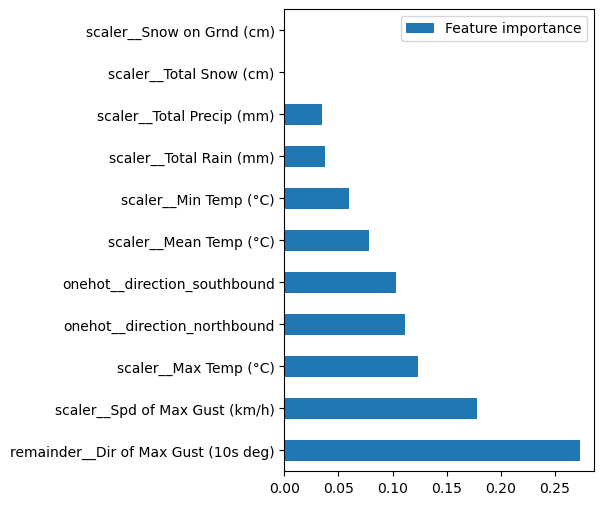

In [31]:
def plot_feature_importances(model, figsize=(4,6)):
    importances = pd.DataFrame({'Feature importance': model.feature_importances_}, 
                           index=ct.get_feature_names_out()).sort_values(by='Feature importance',ascending=False)
    importances.plot.barh(figsize=figsize);

plot_feature_importances(model)

### Exporting the Model

In [32]:
ct_filename = 'commute_estimator_ct.pkl'
with open(ct_filename, 'wb') as file:
    pickle.dump(ct, file)

In [33]:
model_filename = 'commute_estimator_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)